In [1]:
#meta 3/23/2022 TensorFlow Dataset API
# src course Introduction to TensorFlow
# git clone https://github.com/GoogleCloudPlatform/training-data-analyst 
# file src: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/labs/2_dataset_api.ipynb

#infra: work laptop, env anya_tf2

#In the notebook interface, navigate to 
#  training-data-analyst > courses > machine_learning > deepdive2 > introduction_to_tensorflow > labs, 
#  and open 2_dataset_api.ipynb
#Look at the complete solution, navigate to 
#  training-data-analyst > courses > machine_learning > deepdive2 > introduction_to_tensorflow > solutions, 
#  and open 2_dataset_api.ipynb

#history
#3/23/2022 REVIEW
#      How to use tf.data to read data from memory
#      How to use tf.data in a training loop
#      How to use tf.data to read data from disk
#      Learn how to write production input pipelines with feature engineering (batching, shuffling, etc.)

#      myPreviews:
#      Preview what's in tempds (class tensorflow.python.data.ops.dataset_ops.PrefetchDataset) - by iteration over items in ds
#      Preview what's in tempds - without iteration
#      Cleaner preview offered by Solution file
#      Transforming the features
#      $myComment: fancy create_dataset()
#      $myComment: fancy input pipeline create_dataset()

# Reference
#Preview a .csv file
#  my_Intro2TF_load_diff_filedata.ipynb 
#take() method of tf.data.Dataset
#  2_dataset_api_solution.ipynb

# TensorFlow Dataset API

**Learning Objectives**
1. Learn how to use tf.data to read data from memory
1. Learn how to use tf.data in a training loop
1. Learn how to use tf.data to read data from disk
1. Learn how to write production input pipelines with feature engineering (batching, shuffling, etc.)


In this notebook, we will start by refactoring the linear regression we implemented in the previous lab so that it takes data from a`tf.data.Dataset`, and we will learn how to implement **stochastic gradient descent** with it. In this case, the original dataset will be synthetic and read by the `tf.data` API directly  from memory.

In a second part, we will learn how to load a dataset with the `tf.data` API when the dataset resides on disk.

Each learning objective will correspond to a __#TODO__  in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/2_dataset_api.ipynb).


In [2]:
import json
import math
import os
from pprint import pprint

import numpy as np
import tensorflow as tf
print(tf.version.VERSION)

2.6.3


## Loading data from memory

### Creating the dataset

Let's consider the synthetic dataset of the previous section:

In [3]:
N_POINTS = 10
X = tf.constant(range(N_POINTS), dtype=tf.float32)
Y = 2 * X + 10

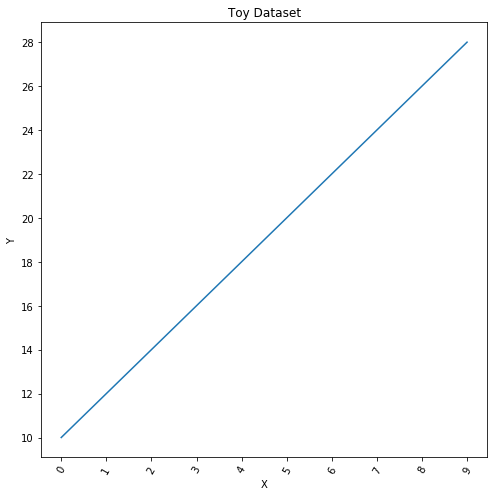

In [4]:
#$my
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(X,Y)
plt.title("Toy Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.yticks(Y)
plt.xticks(X, rotation=60);


We begin with implementing a function that takes as input


- our $X$ and $Y$ vectors of synthetic data generated by the linear function $y= 2x + 10$
- the number of passes over the dataset we want to train on (`epochs`)
- the size of the batches the dataset (`batch_size`)

and returns a `tf.data.Dataset`: 

**Remark:** Note that the last batch may not contain the exact number of elements you specified because the dataset was exhausted.

If you want batches with the exact same number of elements per batch, we will have to discard the last batch by
setting:

```python
dataset = dataset.batch(batch_size, drop_remainder=True)
```

We will do that here.

**Lab Task #1:** Complete the code below to 
1. instantiate a `tf.data` dataset using [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices).
2. Set up the dataset to 
  * repeat `epochs` times,
  * create a batch of size `batch_size`, ignoring extra elements when the batch does not divide the number of input elements evenly.

In [5]:
# TODO 1
def create_dataset(X, Y, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y)) # TODO -- Your code here.
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True) # TODO -- Your code here.
    return dataset

Let's test our function by iterating twice over our dataset in batches of 3 datapoints:

In [6]:
BATCH_SIZE = 3
EPOCH = 2

dataset = create_dataset(X, Y, epochs=EPOCH, batch_size=BATCH_SIZE)

for i, (x, y) in enumerate(dataset):
    print("x:", x.numpy(), "y:", y.numpy())
    assert len(x) == BATCH_SIZE
    assert len(y) == BATCH_SIZE

x: [0. 1. 2.] y: [10. 12. 14.]
x: [3. 4. 5.] y: [16. 18. 20.]
x: [6. 7. 8.] y: [22. 24. 26.]
x: [9. 0. 1.] y: [28. 10. 12.]
x: [2. 3. 4.] y: [14. 16. 18.]
x: [5. 6. 7.] y: [20. 22. 24.]


In [7]:
#$my
for i in enumerate(dataset): #class 'tuple' of len(2)
    print(i[0])
    print(i[1])

0
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([10., 12., 14.], dtype=float32)>)
1
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([16., 18., 20.], dtype=float32)>)
2
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([22., 24., 26.], dtype=float32)>)
3
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([9., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([28., 10., 12.], dtype=float32)>)
4
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([14., 16., 18.], dtype=float32)>)
5
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([5., 6., 7.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([20., 22., 24.

### Loss function and gradients

The loss function and the function that computes the gradients are the same as before:

In [8]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)


def compute_gradients(X, Y, w0, w1):
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return tape.gradient(loss, [w0, w1])

### Training loop

The main difference now is that now, in the traning loop, we will iterate directly on the `tf.data.Dataset` generated by our `create_dataset` function. 

We will configure the dataset so that it iterates 250 times over our synthetic dataset in batches of 2.

**Lab Task #2:** Complete the code in the cell below to call your dataset above when training the model. Note that the `step, (X_batch, Y_batch)` iterates over the `dataset`. The inside of the `for` loop should be exactly as in the previous lab. 

In [9]:
# TODO 2
EPOCHS = 250
BATCH_SIZE = 2
LEARNING_RATE = .02

MSG = "STEP {step} - loss: {loss}, w0: {w0}, w1: {w1}\n"

w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dataset = create_dataset(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE) # TODO -- Your code here.

for step, (X_batch, Y_batch) in enumerate(dataset): # TODO -- Your code here.

    dw0, dw1 = compute_gradients(X_batch, Y_batch, w0, w1) # TODO -- Your code here.
    # TODO -- Your code here.
    w0.assign_sub(dw0 * LEARNING_RATE)
    w1.assign_sub(dw1 * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(X_batch, Y_batch, w0, w1) # TODO -- Your code here.
        print(MSG.format(step=step, loss=loss, w0=w0.numpy(), w1=w1.numpy()))
        
assert loss < 0.0001
assert abs(w0 - 2) < 0.001
assert abs(w1 - 10) < 0.001

STEP 0 - loss: 109.76800537109375, w0: 0.23999999463558197, w1: 0.4399999976158142

STEP 100 - loss: 9.363959312438965, w0: 2.55655837059021, w1: 6.674341678619385

STEP 200 - loss: 1.393267273902893, w0: 2.2146825790405273, w1: 8.717182159423828

STEP 300 - loss: 0.20730558037757874, w0: 2.082810878753662, w1: 9.505172729492188

STEP 400 - loss: 0.03084510937333107, w0: 2.03194260597229, w1: 9.809128761291504

STEP 500 - loss: 0.004589457996189594, w0: 2.012321710586548, w1: 9.926374435424805

STEP 600 - loss: 0.0006827632314525545, w0: 2.0047526359558105, w1: 9.971602439880371

STEP 700 - loss: 0.00010164896957576275, w0: 2.0018346309661865, w1: 9.989042282104492

STEP 800 - loss: 1.5142451957217418e-05, w0: 2.000706911087036, w1: 9.995771408081055

STEP 900 - loss: 2.256260358990403e-06, w0: 2.0002737045288086, w1: 9.998367309570312

STEP 1000 - loss: 3.3405058275093324e-07, w0: 2.000105381011963, w1: 9.999371528625488

STEP 1100 - loss: 4.977664502803236e-08, w0: 2.000040054321289,

## Loading data from disk

### Locating the CSV files

We will start with the **taxifare dataset** CSV files that we wrote out in a previous lab. 

The taxifare dataset files have been saved into `../toy_data`.

Check that it is the case in the cell below, and, if not, regenerate the taxifare


In [10]:
#$my - works in Linux/Unix system, ie. G Colab
!ls -l ../toy_data/taxi*.csv

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
%%bash
ls -l data/toy_data/taxi*.csv

-rw-r--r-- 1 chq-anyac 1049089  61473 Mar 23 13:16 data/toy_data/taxi-test.csv
-rw-r--r-- 1 chq-anyac 1049089 288831 Mar 23 13:16 data/toy_data/taxi-train.csv
-rw-r--r-- 1 chq-anyac 1049089  61082 Mar 23 13:16 data/toy_data/taxi-valid.csv


$my Preview a .csv file  
Refer to my_Intro2TF_load_diff_filedata.ipynb

In [12]:
%%bash
head 'data/toy_data/taxi-valid.csv' 

5.3,2012-01-03 19:21:35 UTC,-73.962627,40.763214,-73.973485,40.753353,1,0
25.3,2010-09-27 07:30:15 UTC,-73.965799,40.794243,-73.927134,40.852261,3,1
27.5,2015-05-19 00:40:02 UTC,-73.86344146728516,40.76899719238281,-73.96058654785156,40.76129913330078,1,2
5.7,2010-04-29 12:28:00 UTC,-73.989255,40.738912,-73.97558,40.749172,1,3
11.5,2013-06-23 06:08:09 UTC,-73.99731,40.763735,-73.955657,40.768141,1,4
18.0,2014-10-14 18:52:03 UTC,-73.997995,40.761638,-74.008985,40.712442,1,5
4.9,2010-04-29 12:28:00 UTC,-73.977315,40.766182,-73.970845,40.761462,5,6
32.33,2014-02-24 18:22:00 UTC,-73.985358,40.761352,-73.92427,40.699145,1,7
17.0,2015-03-26 02:48:58 UTC,-73.93981170654297,40.846473693847656,-73.97361755371094,40.786983489990234,1,8
12.5,2013-04-09 09:39:13 UTC,-73.977323,40.753934,-74.00719,40.741472,1,9


### Use tf.data to read the CSV files

The `tf.data` API can easily read csv files using the helper function tf.data.experimental.make_csv_dataset

If you have TFRecords (which is recommended), you may use tf.data.experimental.make_batched_features_dataset

The first step is to define 

- the feature names into a list `CSV_COLUMNS`
- their default values into a list `DEFAULTS`

In [13]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]

Let's now wrap the call to `make_csv_dataset` into its own function that will take only the file pattern (i.e. glob) where the dataset files are to be located:

**Lab Task #3:** Complete the code in the `create_dataset(...)` function below to return a `tf.data` dataset made from the `make_csv_dataset`. Have a look at the [documentation here](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset). The `pattern` will be given as an argument of the function but you should set the `batch_size`, `column_names` and `column_defaults`.

In [14]:
# TODO 3
def create_dataset(pattern):
    # TODO -- Your code here.
    #$myComment - no label
    dataset = tf.data.experimental.make_csv_dataset(pattern, 1, CSV_COLUMNS, DEFAULTS)
    return dataset


In [15]:
tempds = create_dataset('data/toy_data/taxi-valid*') #$my class tensorflow.python.data.ops.dataset_ops.PrefetchDataset
print(tempds)

<PrefetchDataset shapes: OrderedDict([(fare_amount, (1,)), (pickup_datetime, (1,)), (pickup_longitude, (1,)), (pickup_latitude, (1,)), (dropoff_longitude, (1,)), (dropoff_latitude, (1,)), (passenger_count, (1,)), (key, (1,))]), types: OrderedDict([(fare_amount, tf.float32), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.float32), (key, tf.string)])>


#### $my Preview what's in tempds - by iteration over items in tempds
Not recommended to iterate

In [16]:
#$my preview what's in tempds - by iteration over items in tempds
i = 0
i_exit = 2

for item in tempds: # in class tensorflow.python.data.ops.dataset_ops.PrefetchDataset
    if i == i_exit: 
        break #exit here
    
    print(item) #class 'collections.OrderedDict'
    print()
    i += 1

OrderedDict([('fare_amount', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.9], dtype=float32)>), ('pickup_datetime', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2010-12-21 13:08:00 UTC'], dtype=object)>), ('pickup_longitude', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.994896], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.740196], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.96087], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.757412], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>), ('key', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'169'], dtype=object)>)])

OrderedDict([('fare_amount', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([30.83], dtype=float32)>), ('pickup_datetime', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'20

In [17]:
#$my preview what's in tempds - by iteration over items in tempds
i = 0
i_exit = 2

for item in tempds: # in class tensorflow.python.data.ops.dataset_ops.PrefetchDataset
    if i == i_exit: 
        break #exit here
    
    #print(item) #class 'collections.OrderedDict'
    #refer to https://www.geeksforgeeks.org/ordereddict-in-python/
    for k,v in item.items(): # in items of class collections.OrderedDict 
        print("{}: {}".format(k,v))
        
    print()
    i += 1

fare_amount: [4.5]
pickup_datetime: [b'2012-04-06 15:52:48 UTC']
pickup_longitude: [-73.992455]
pickup_latitude: [40.739414]
dropoff_longitude: [-74.00201]
dropoff_latitude: [40.74503]
passenger_count: [1.]
key: [b'415']

fare_amount: [8.5]
pickup_datetime: [b'2011-12-03 10:28:00 UTC']
pickup_longitude: [-73.99092]
pickup_latitude: [40.751083]
dropoff_longitude: [-73.96866]
dropoff_latitude: [40.75236]
passenger_count: [1.]
key: [b'91']



Another way to iterate over items in tempds (not recommended to iterate)  
`next` method with an iterator

In [18]:
#$my preview what's in tempds
iterator = iter(tempds)
example = next(iterator) #class collections.OrderedDict

example

OrderedDict([('fare_amount',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([11.7], dtype=float32)>),
             ('pickup_datetime',
              <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2009-05-27 20:37:00 UTC'], dtype=object)>),
             ('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.95558], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.768337], dtype=float32)>),
             ('dropoff_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98626], dtype=float32)>),
             ('dropoff_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.73497], dtype=float32)>),
             ('passenger_count',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.], dtype=float32)>),
             ('key',
              <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], 

In [19]:
#$my preview
for k,v in example.items():
    print(k)
    print(v) #class 'tensorflow.python.framework.ops.EagerTensor'


fare_amount
tf.Tensor([11.7], shape=(1,), dtype=float32)
pickup_datetime
tf.Tensor([b'2009-05-27 20:37:00 UTC'], shape=(1,), dtype=string)
pickup_longitude
tf.Tensor([-73.95558], shape=(1,), dtype=float32)
pickup_latitude
tf.Tensor([40.768337], shape=(1,), dtype=float32)
dropoff_longitude
tf.Tensor([-73.98626], shape=(1,), dtype=float32)
dropoff_latitude
tf.Tensor([40.73497], shape=(1,), dtype=float32)
passenger_count
tf.Tensor([5.], shape=(1,), dtype=float32)
key
tf.Tensor([b'211'], shape=(1,), dtype=string)


#### $my Preview what's in tempds - without iteration
Start by reusing custom function `show_batch` from load_diff_filedata.ipynb  
`take()` method of `tf.data.Dataset` used for limiting number of items in dataset

How to use dataset api take() method in TensorFlow https://www.gcptutorials.com/article/how-to-use-take-method-in-tensorflow  


In [20]:
#$myComment: this code from load_diff_filedata.ipynb wouldn't work here because tempds doesn't contain a label
def show_batch(dataset):
  for batch, label in dataset.take(1):
    print()
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

#show_batch(tempds)

In [21]:
#$my - show batch without a label
def show_batch(dataset):
  for batch in dataset.take(2):
    print()
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

show_batch(tempds)


fare_amount         : [22.5]
pickup_datetime     : [b'2013-12-06 14:55:00 UTC']
pickup_longitude    : [-73.980965]
pickup_latitude     : [40.733597]
dropoff_longitude   : [-73.971825]
dropoff_latitude    : [40.790337]
passenger_count     : [1.]
key                 : [b'471']

fare_amount         : [8.9]
pickup_datetime     : [b'2009-05-27 20:37:00 UTC']
pickup_longitude    : [-73.9611]
pickup_latitude     : [40.760666]
dropoff_longitude   : [-73.97741]
dropoff_latitude    : [40.758404]
passenger_count     : [2.]
key                 : [b'534']


#### $my Cleaner preview offered by Solution 
Refer to 2_dataset_api_solution.ipynb

In [22]:
# Let's iterate over the first two element of this dataset using `dataset.take(2)`.
# Then convert them ordinary Python dictionary with numpy array as values for more readability:
for data in tempds.take(2):
    pprint({k: v.numpy() for k, v in data.items()})
    print("\n")

{'dropoff_latitude': array([40.750004], dtype=float32),
 'dropoff_longitude': array([-73.991234], dtype=float32),
 'fare_amount': array([6.5], dtype=float32),
 'key': array([b'88'], dtype=object),
 'passenger_count': array([3.], dtype=float32),
 'pickup_datetime': array([b'2009-09-24 21:36:16 UTC'], dtype=object),
 'pickup_latitude': array([40.75538], dtype=float32),
 'pickup_longitude': array([-73.97921], dtype=float32)}


{'dropoff_latitude': array([40.75586], dtype=float32),
 'dropoff_longitude': array([-73.9728], dtype=float32),
 'fare_amount': array([26.1], dtype=float32),
 'key': array([b'333'], dtype=object),
 'passenger_count': array([1.], dtype=float32),
 'pickup_datetime': array([b'2012-02-19 23:10:09 UTC'], dtype=object),
 'pickup_latitude': array([40.774113], dtype=float32),
 'pickup_longitude': array([-73.87464], dtype=float32)}




Note that this is a prefetched dataset, where each element is an `OrderedDict` whose keys are the feature names and whose values are tensors of shape `(1,)` (i.e. vectors).

Let's iterate over the two first element of this dataset using `dataset.take(2)` and let's convert them ordinary Python dictionary with numpy array as values for more readability:

### Transforming the features

What we really need is a dictionary of features + a label. So, we have to do two things to the above dictionary:

1. Remove the unwanted column "key"
1. Keep the label separate from the features

Let's first implement a function that takes as input a row (represented as an `OrderedDict` in our `tf.data.Dataset` as above) and then returns a tuple with two elements:

* The first element being the same `OrderedDict` with the label dropped
* The second element being the label itself (`fare_amount`)

Note that we will need to also remove the `key` and `pickup_datetime` column, which we won't use.

**Lab Task #4a:** Complete the code in the `features_and_labels(...)` function below. Your function should return a dictionary of features and a label. Keep in mind `row_data` is already a dictionary and you will need to remove the `pickup_datetime` and `key` from `row_data` as well.

In [23]:
UNWANTED_COLS = ['pickup_datetime', 'key']

# TODO 4a
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN) # TODO -- Your code here.
    features = row_data # TODO -- Your code here.
    
    # TODO -- Your code here.
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label

Let's iterate over 2 examples from our `tempds` dataset and apply our `feature_and_labels`
function to each of the examples to make sure it's working:

In [24]:
for row_data in tempds.take(2):
    features, label = features_and_labels(row_data)
    pprint(features)
    print(label, "\n")
    assert UNWANTED_COLS[0] not in features.keys()
    assert UNWANTED_COLS[1] not in features.keys()
    assert label.shape == [1]

OrderedDict([('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98089], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.741863], dtype=float32)>),
             ('dropoff_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98028], dtype=float32)>),
             ('dropoff_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.73056], dtype=float32)>),
             ('passenger_count',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)])
tf.Tensor([9.], shape=(1,), dtype=float32) 

OrderedDict([('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98661], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.762264], dtype=float32)>),
             ('dropoff_longitude',
              <tf.T

#### $my Transforming the features

In [25]:
#$my Transforming the features manually
#reusing LABEL_COLUMN and UNWANTED_COLS

for row_data in tempds.take(2): #class 'collections.OrderedDict'
    
    print("\nRaw row data: ")
    pprint(row_data)
    
    #transform into features and target
    label = row_data.pop(LABEL_COLUMN)
    print("Transformed row into target and features: ")
    print(label)
    [row_data.pop(unwanted_col) for unwanted_col in UNWANTED_COLS]     
    pprint(row_data)



Raw row data: 
OrderedDict([('fare_amount',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([13.], dtype=float32)>),
             ('pickup_datetime',
              <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2013-12-21 06:21:00 UTC'], dtype=object)>),
             ('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.96892], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.758507], dtype=float32)>),
             ('dropoff_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.94245], dtype=float32)>),
             ('dropoff_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.80632], dtype=float32)>),
             ('passenger_count',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.], dtype=float32)>),
             ('key',
              <tf.Tensor: shape=(1,), dtype=string, numpy=a

### Batching

Let's now refactor our `create_dataset` function so that it takes an additional argument `batch_size` and batch the data correspondingly. We will also use the `features_and_labels` function we implemented for our dataset to produce tuples of features and labels.

**Lab Task #4b:** Complete the code in the `create_dataset(...)` function below to return a `tf.data` dataset made from the `make_csv_dataset`. Now, the `pattern` and `batch_size` will be given as an arguments of the function but you should set the `column_names` and `column_defaults` as before. You will also apply a `.map(...)` method to create features and labels from each example. 

In [26]:
# TODO 4b
def create_dataset(pattern, batch_size):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels) # TODO -- Your code here. #$myComment: fancy create_dataset()

    return dataset

Let's test that our batches are of the right size:

In [27]:
BATCH_SIZE = 2

tempds = create_dataset('data/toy_data/taxi-train*', batch_size=2) #$my

for X_batch, Y_batch in tempds.take(2):
    pprint({k: v.numpy() for k, v in X_batch.items()})
    print(Y_batch.numpy(), "\n")
    assert len(Y_batch) == BATCH_SIZE

{'dropoff_latitude': array([40.762424, 40.728287], dtype=float32),
 'dropoff_longitude': array([-73.96815 , -73.995415], dtype=float32),
 'passenger_count': array([1., 1.], dtype=float32),
 'pickup_latitude': array([40.757572, 40.707973], dtype=float32),
 'pickup_longitude': array([-73.9606  , -74.006546], dtype=float32)}
[6.5 8.9] 

{'dropoff_latitude': array([40.768185, 40.722935], dtype=float32),
 'dropoff_longitude': array([-73.96859 , -74.004845], dtype=float32),
 'passenger_count': array([1., 1.], dtype=float32),
 'pickup_latitude': array([40.704605, 40.738243], dtype=float32),
 'pickup_longitude': array([-74.00777 , -74.000015], dtype=float32)}
[20.1  5.5] 



### Shuffling

When training a deep learning model in batches over multiple workers, it is helpful if we shuffle the data. That way, different workers will be working on different parts of the input file at the same time, and so averaging gradients across workers will help. Also, during training, we will need to read the data indefinitely.

Let's refactor our `create_dataset` function so that it shuffles the data, when the dataset is used for training.

We will introduce an additional argument `mode` to our function to allow the function body to distinguish the case
when it needs to shuffle the data (`mode == 'train'`) from when it shouldn't (`mode == 'eval'`).

Also, before returning we will want to prefetch 1 data point ahead of time (`dataset.prefetch(1)`) to speed-up training:

**Lab Task #4c:** The last step of our `tf.data` dataset will specify shuffling and repeating of our dataset pipeline. Complete the code below to add these three steps to the Dataset pipeline
1. follow the `.map(...)` operation which extracts features and labels with a call to `.cache()` the result.
2. during training, use `.shuffle(...)` and `.repeat()` to shuffle batches and repeat the dataset
3. use `.prefetch(...)` to take advantage of multi-threading and speedup training.

In [28]:
# TODO 4c
#$myComment: fancy input pipeline create_dataset()

def create_dataset(pattern, batch_size=1, mode="eval"):
# The tf.data.experimental.make_csv_dataset() method reads CSV files into a dataset
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS) # TODO -- Your code here.

# The map() function executes a specified function for each item in an iterable.
# The item is sent to the function as a parameter.
    dataset = dataset.map(features_and_labels).cache() # TODO -- Your code here.

    if mode == "train":
        dataset = dataset.shuffle(1000).repeat() # TODO -- Your code here.

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

Let's check that our function works well in both modes:

In [29]:
tempds = create_dataset('data/toy_data/taxi-train*', 2, 'train')
print(list(tempds.take(1)))

[(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.95741, -73.99501], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.76948 , 40.744877], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.98585, -73.99646], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.76165, 40.73549], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)]), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([8.6, 5. ], dtype=float32)>)]


In [30]:
tempds = create_dataset('data/toy_data/taxi-valid*', 2, 'eval')
print(list(tempds.take(1)))

[(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.91153, -73.98536], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.76809 , 40.761353], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.939026, -73.92427 ], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.81655 , 40.699146], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 1.], dtype=float32)>)]), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([20.83, 32.33], dtype=float32)>)]


In the next notebook, we will build the model using this input pipeline.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.